In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
print(keras.__version__)

2.3.1
2.4.0


## Data 준비하기

In [3]:
# https://www.robots.ox.ac.uk/~vgg/data/pets/ 사이트에서 dataset download

In [4]:
## oxford_pet.zip이 보이는지 확인
#!ls -l

In [5]:
## 압축풀기
#!unzip -q oxford_pet.zip -d oxford_pet

In [6]:
## 압축이 풀린 directory 확인
#!ls oxford_pet

In [7]:
## directory 설정
cur_dir = os.getcwd()
data_dir = cur_dir
#data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [8]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [9]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

In [10]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [11]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [12]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [13]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [14]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [15]:
image_files.sort()

In [16]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [17]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [18]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [19]:
print(len(train_images), len(val_images))

5920 1458


## TFRecord 만들기

In [20]:
IMG_SIZE = 224

In [21]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [22]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [23]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [24]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [25]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


In [26]:
#!ls -l $tfr_dir

## Classification

### 37개 Class로 classification 하기

In [27]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 30 # 40을 30로 조정함. 메모리 부족 오류 발생
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [28]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, label

In [29]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [30]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

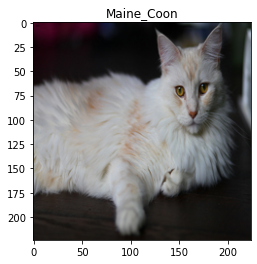

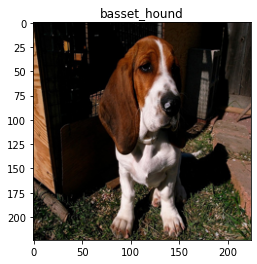

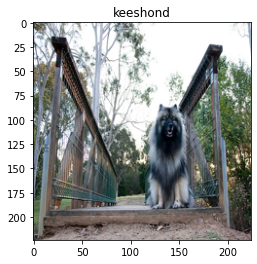

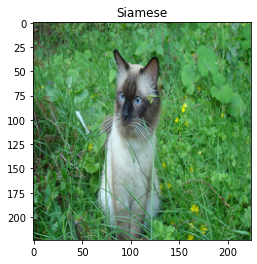

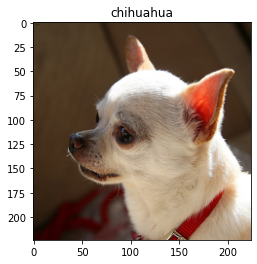

In [31]:
for images, labels in train_dataset.take(5):
  plt.imshow(images[0])
  title = class_list[labels[0].numpy()]
  plt.title(title)
  plt.show()

In [32]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [33]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [34]:
def create_mv_model():
  mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
  gap = GlobalAveragePooling2D()(mobilenetv2.output)
  output = Dense(N_CLASS, activation='softmax', name='output_layer')(gap)
  return keras.Model(inputs=mobilenetv2.input, outputs=output)  

In [35]:
## Create model, compile & summary
model1 = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model1.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [36]:
history = model1.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
198/197 [==============================] - 27s 137ms/step - loss: 1.1270 - accuracy: 0.7169 - val_loss: 0.5012 - val_accuracy: 0.8292
Epoch 2/20
198/197 [==============================] - 27s 136ms/step - loss: 0.2336 - accuracy: 0.9351 - val_loss: 0.3990 - val_accuracy: 0.8635
Epoch 3/20
198/197 [==============================] - 27s 136ms/step - loss: 0.1087 - accuracy: 0.9745 - val_loss: 0.3584 - val_accuracy: 0.8779
Epoch 4/20
198/197 [==============================] - 26s 132ms/step - loss: 0.0569 - accuracy: 0.9909 - val_loss: 0.3045 - val_accuracy: 0.8964
Epoch 5/20
198/197 [==============================] - 28s 140ms/step - loss: 0.0346 - accuracy: 0.9958 - val_loss: 0.2926 - val_accuracy: 0.9040
Epoch 6/20
198/197 [==============================] - 28s 142ms/step - loss: 0.0173 - accuracy: 0.9992 - val_loss: 0.2658 - val_accuracy: 0.9088
Epoch 7/20
198/197 [==============================] - 28s 140ms/step - loss: 0.0138 - accuracy: 0.9995 - val_loss: 0.2497 - val_ac

### Class Activation Map 만들기

In [37]:
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [38]:
target_fmap = model1.get_layer(name='out_relu').output
new_model1 = keras.models.Model(model1.input, target_fmap)

In [39]:
weights = model1.get_layer(name='output_layer').get_weights()[0]

In [40]:
weights.shape

(1280, 37)

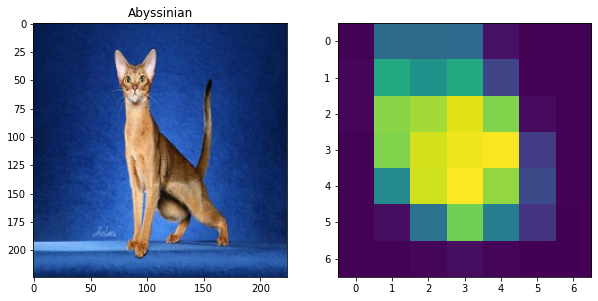

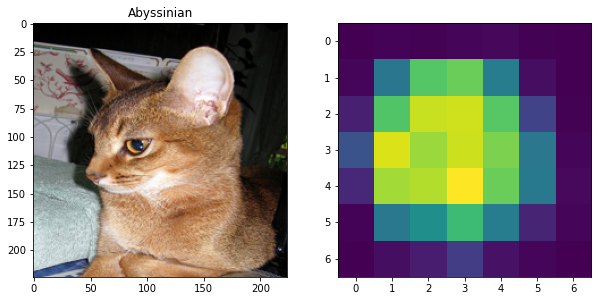

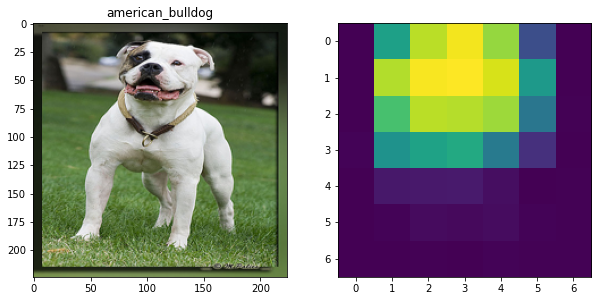

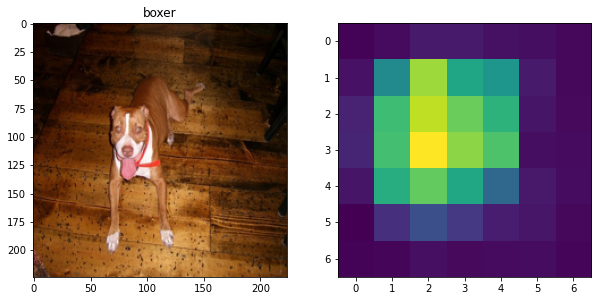

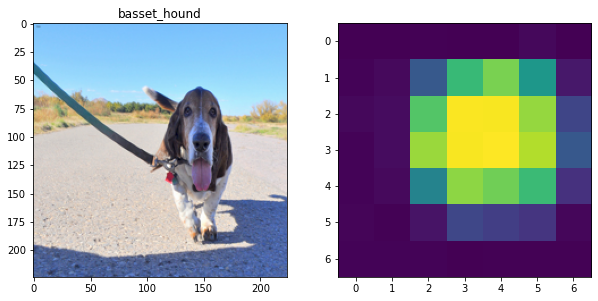

In [41]:
for images, labels in val_dataset.take(5):
  plt.figure(figsize=(10,6))

  plt.subplot(1,2,1)
  plt.imshow(images[0])
  prediction = model1.predict(images)
  pred_class = np.argmax(prediction[0], -1)
  title = class_list[pred_class]
  plt.title(title)

  plt.subplot(1,2,2)
  fmap = new_model1(images)
  weights_cam = weights[:,pred_class]
  camsum = np.zeros((7,7))
  for i in range(1280):
    camsum += weights_cam[i]*fmap[0,:,:,i]
  camsum = camsum / 1280
  plt.imshow(camsum)
  
  plt.show()

### 고양이/개 2 Class로 classification 하기

In [42]:
N_CLASS = 2

In [43]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, bi_cls_label

In [44]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [45]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

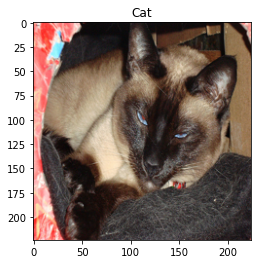

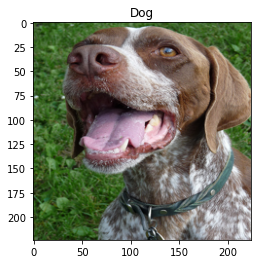

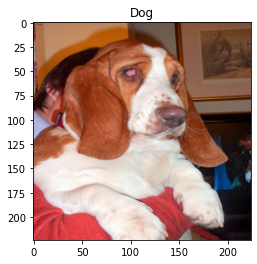

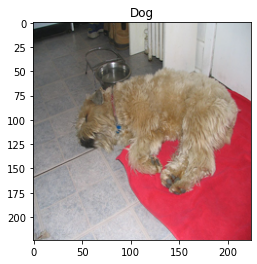

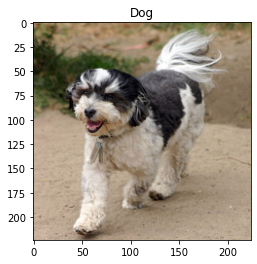

In [46]:
for images, labels in train_dataset.take(5):
  plt.imshow(images[0])
  if labels[0] == 0:
    title = 'Dog'
  else:
    title = 'Cat'
  plt.title(title)
  plt.show()

In [47]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [48]:
def create_mv_model():
  mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
  gap = GlobalAveragePooling2D()(mobilenetv2.output)
  output = Dense(N_CLASS, activation='softmax', name='output_layer')(gap)
  return keras.Model(inputs=mobilenetv2.input, outputs=output)  

In [49]:
## Create model, compile & summary
model2 = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model2.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [50]:
history = model2.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
198/197 [==============================] - 28s 141ms/step - loss: 0.0802 - accuracy: 0.9686 - val_loss: 0.0423 - val_accuracy: 0.9883
Epoch 2/20
198/197 [==============================] - 28s 141ms/step - loss: 0.0171 - accuracy: 0.9944 - val_loss: 0.0367 - val_accuracy: 0.9897
Epoch 3/20
198/197 [==============================] - 29s 144ms/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.0422 - val_accuracy: 0.9842
Epoch 4/20
198/197 [==============================] - 28s 139ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0210 - val_accuracy: 0.9938
Epoch 5/20
198/197 [==============================] - 28s 140ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0204 - val_accuracy: 0.9945
Epoch 6/20
198/197 [==============================] - 29s 145ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.0185 - val_accuracy: 0.9966
Epoch 7/20
198/197 [==============================] - 28s 143ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0100 - val_ac

### Class Activation Map 만들기

In [51]:
model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [52]:
target_fmap = model2.get_layer(name='out_relu').output
new_model2 = keras.models.Model(model2.input, target_fmap)

In [53]:
weights = model2.get_layer(name='output_layer').get_weights()[0]

In [54]:
weights.shape

(1280, 2)

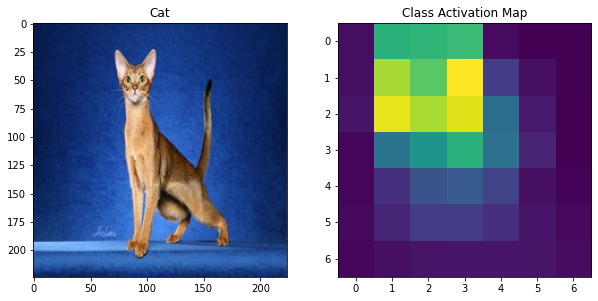

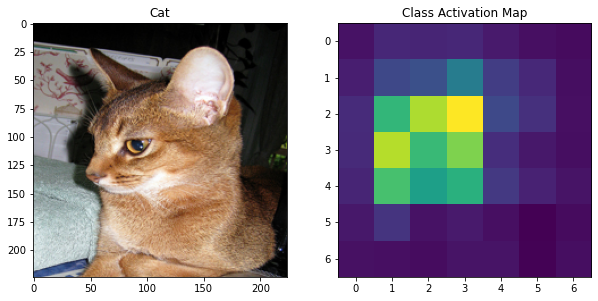

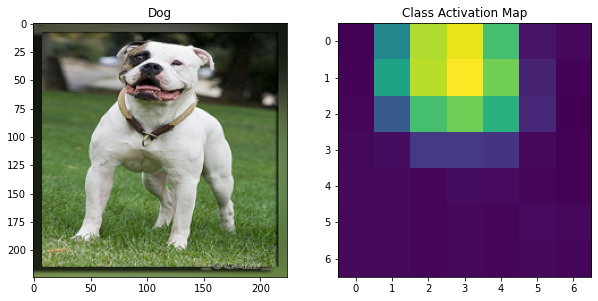

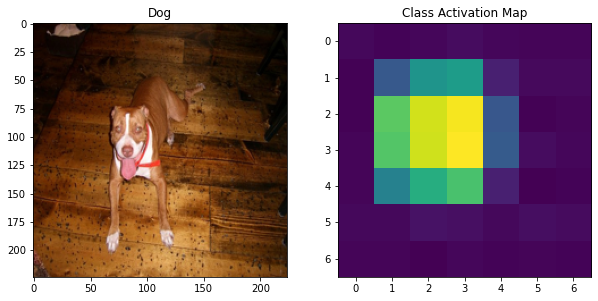

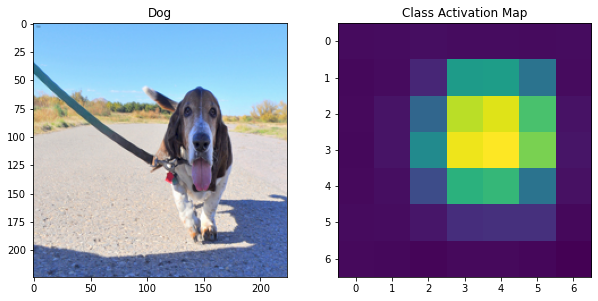

In [55]:
for images, labels in val_dataset.take(5):
  plt.figure(figsize=(10,6))

  plt.subplot(1,2,1)
  plt.imshow(images[0])
  prediction = model2.predict(images)
  pred_class = np.argmax(prediction[0], -1)
  if labels[0] == 0:
    title = 'Dog'
  else:
    title = 'Cat'
  plt.title(title)

  plt.subplot(1,2,2)
  fmap = new_model2(images)
  weights_cam = weights[:,pred_class]
  camsum = np.zeros((7,7))
  for i in range(1280):
    camsum += weights_cam[i]*fmap[0,:,:,i]
  camsum = camsum / 1280
  plt.title('Class Activation Map')
  plt.imshow(camsum)
  
  plt.show()

### 2개 model의 CAM 비교하기

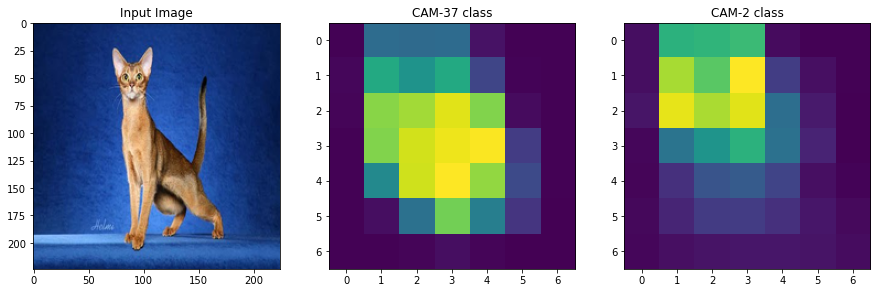

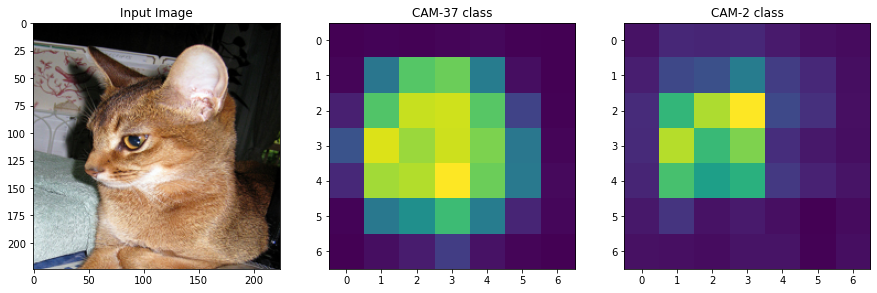

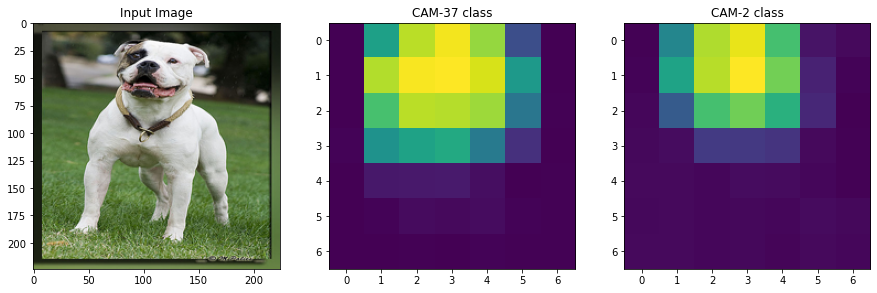

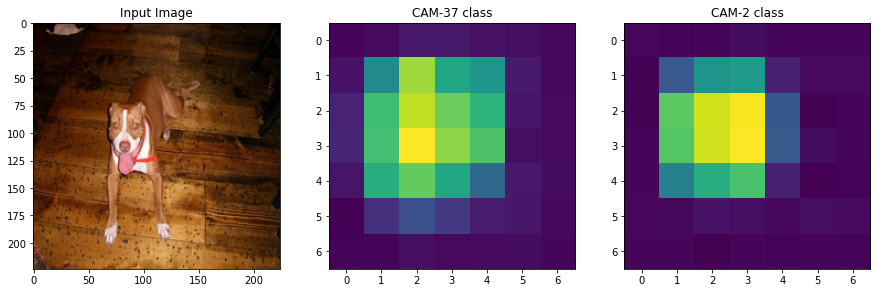

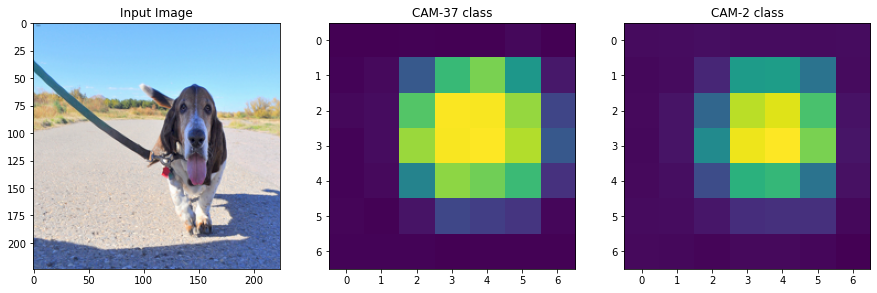

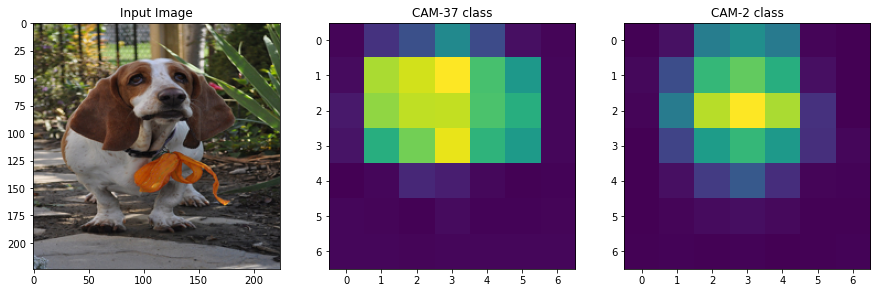

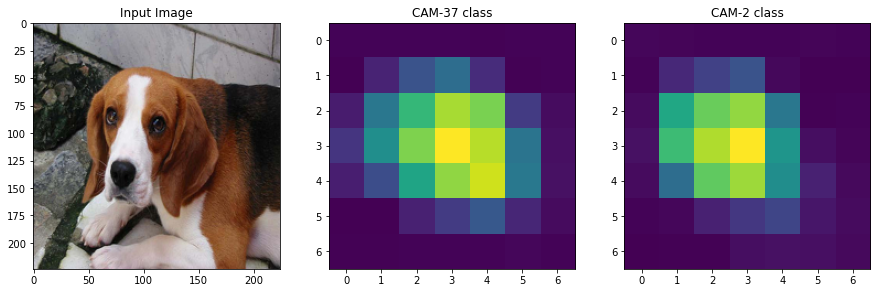

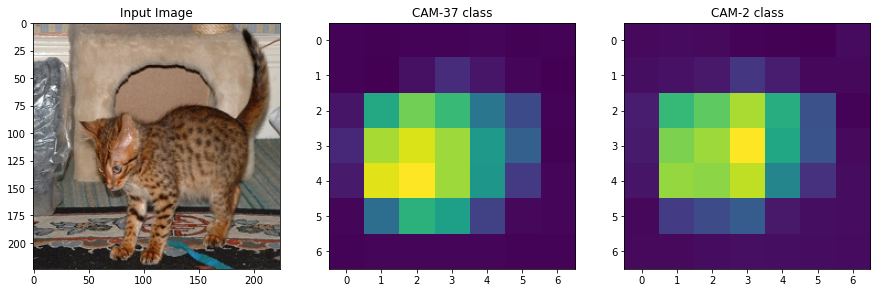

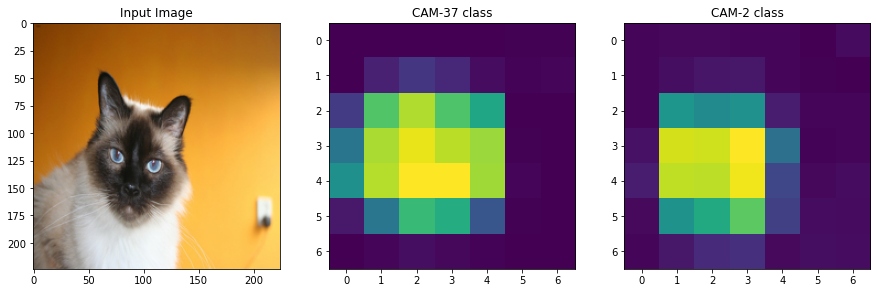

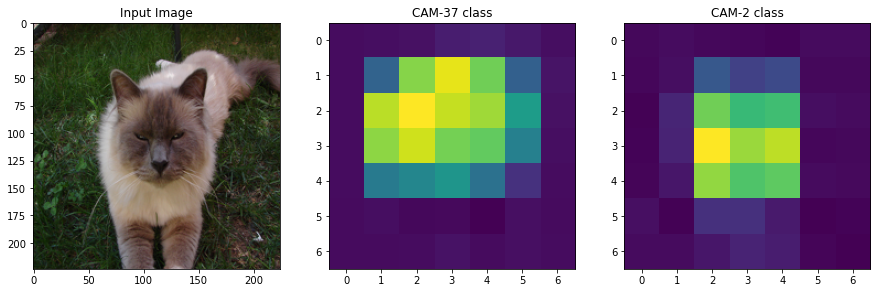

In [56]:
for images, labels in val_dataset.take(10):
  plt.figure(figsize=(15,6))

  plt.subplot(1,3,1)
  plt.imshow(images[0])    
  plt.title('Input Image')

  plt.subplot(1,3,2)
  prediction1 = model1.predict(images)
  pred_class1 = np.argmax(prediction1[0], -1)
  fmap1 = new_model1(images)
  weights1 = model1.get_layer(name='output_layer').get_weights()[0]
  weights_cam1 = weights1[:,pred_class1]
  camsum1 = np.zeros((7,7))
  for i in range(1280):
    camsum1 += weights_cam1[i]*fmap1[0,:,:,i]
  camsum1 = camsum1 / 1280
  plt.title('CAM-37 class')
  plt.imshow(camsum1)

  plt.subplot(1,3,3)
  prediction2 = model2.predict(images)
  pred_class2 = np.argmax(prediction2[0], -1)
  fmap2 = new_model2(images)
  weights2 = model2.get_layer(name='output_layer').get_weights()[0]
  weights_cam2 = weights2[:,pred_class2]
  camsum2 = np.zeros((7,7))
  for i in range(1280):
    camsum2 += weights_cam2[i]*fmap2[0,:,:,i]
  camsum2 = camsum2 / 1280
  plt.title('CAM-2 class')
  plt.imshow(camsum2)
  
  plt.show()